In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DS360 Machine Learning/Course DSML/ML/Time Series Analysis/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.isnull().sum()

,0
Datetime,0
PJME_MW,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df['Datetime']=pd.to_datetime(df['Datetime'])
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [ ]:
df.set_index('Datetime', inplace=True)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
color_pal[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

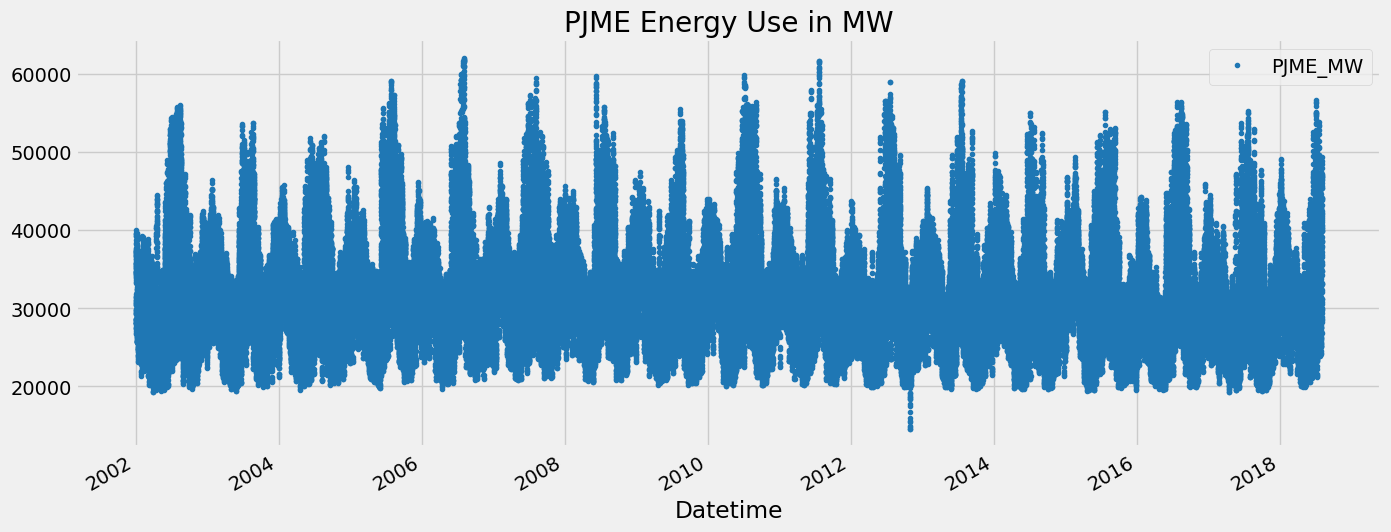

In [ ]:
df.plot(style='.', figsize=(15, 6), color=color_pal[0], title='PJME Energy Use in MW');

In [ ]:
train=df.loc[df.index < "01-01-2015"]
test=df.loc[df.index >= "01-01-2015"]

In [ ]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [ ]:
test

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [ ]:
df.shape

(145366, 1)

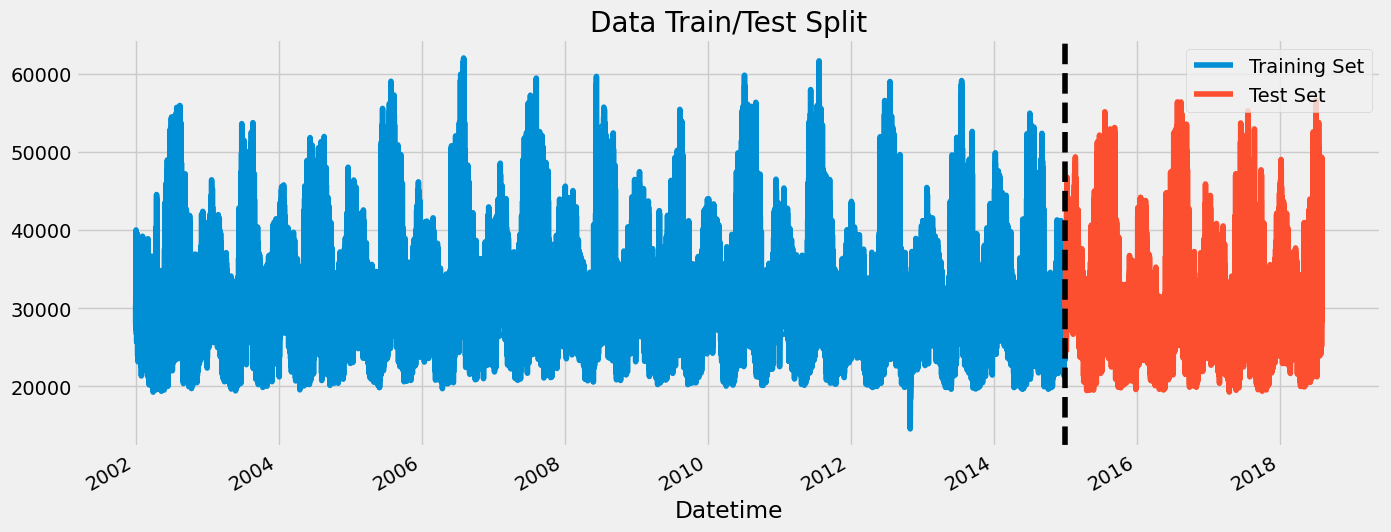

In [ ]:
fig, ax=plt.subplots(figsize=(15, 6))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

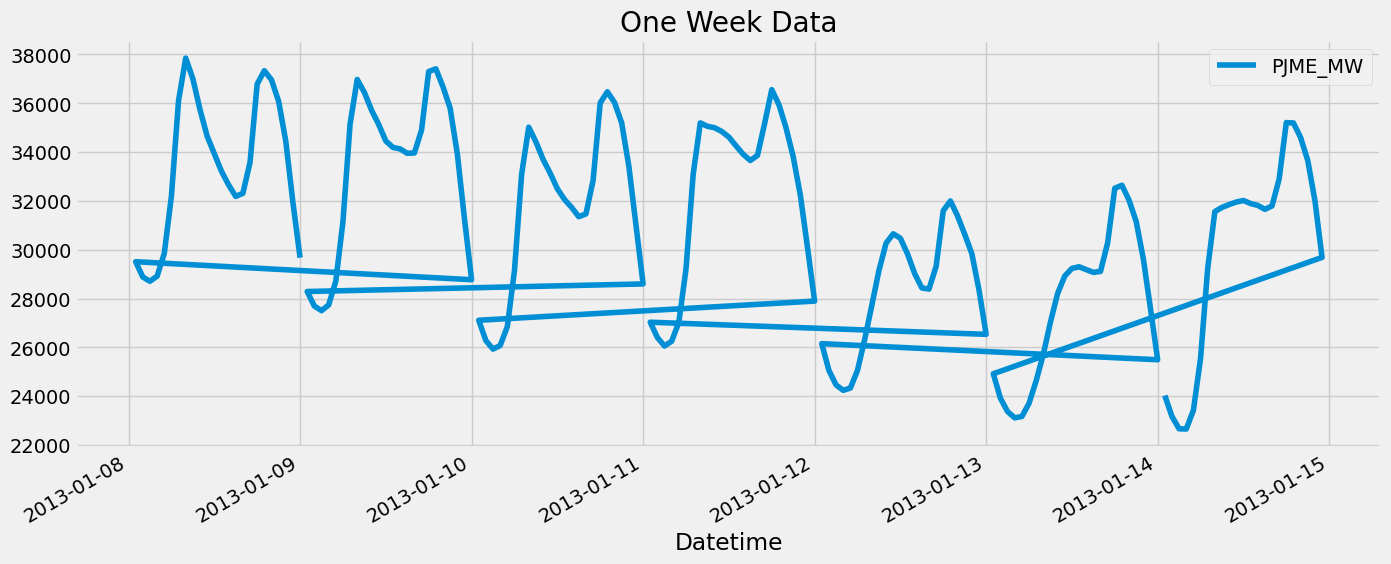

In [ ]:
df.loc[(df.index > "01-08-2013") & (df.index < "01-15-2013")].plot(
    figsize=(15, 6), title='One Week Data'
);

In [ ]:
df.isnull().sum()

,0
PJME_MW,0


In [ ]:
df_resampled=df.loc[(df.index > "01-08-2013") & (df.index < "01-15-2013")].resample('h').mean()

missing_values=df_resampled.isnull().sum()
print(f'Missing values:\n{missing_values}')

Missing values:
PJME_MW    0
dtype: int64


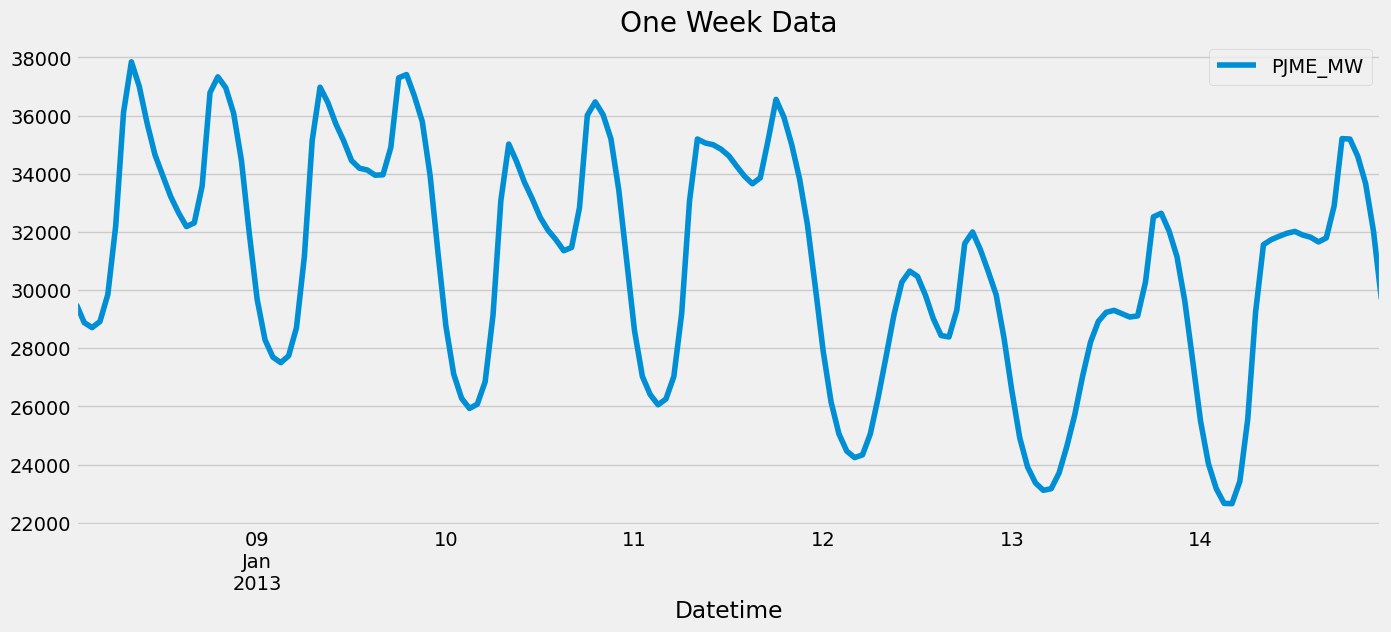

In [ ]:
df_resampled.plot(
    figsize=(15, 6), title='One Week Data'
);

In [ ]:
def create_features(df):
  """
    Create time series features based on time series index.

  """

  df['hour']=df.index.hour
  df['dayofweek']=df.index.dayofweek
  df['month']=df.index.month
  df['dayofmonth']=df.index.day
  df['quarter']=df.index.quarter
  df['year']=df.index.year
  df['dayofyear']=df.index.dayofyear
  df['weekofyear']=df.index.isocalendar().week

  return df

df=create_features(df)
df.head()

,PJME_MW,hour,dayofweek,month,dayofmonth,quarter,year,dayofyear,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,31,4,2002,365,1
2002-12-31 02:00:00,25147.0,2,1,12,31,4,2002,365,1
2002-12-31 03:00:00,24574.0,3,1,12,31,4,2002,365,1
2002-12-31 04:00:00,24393.0,4,1,12,31,4,2002,365,1
2002-12-31 05:00:00,24860.0,5,1,12,31,4,2002,365,1


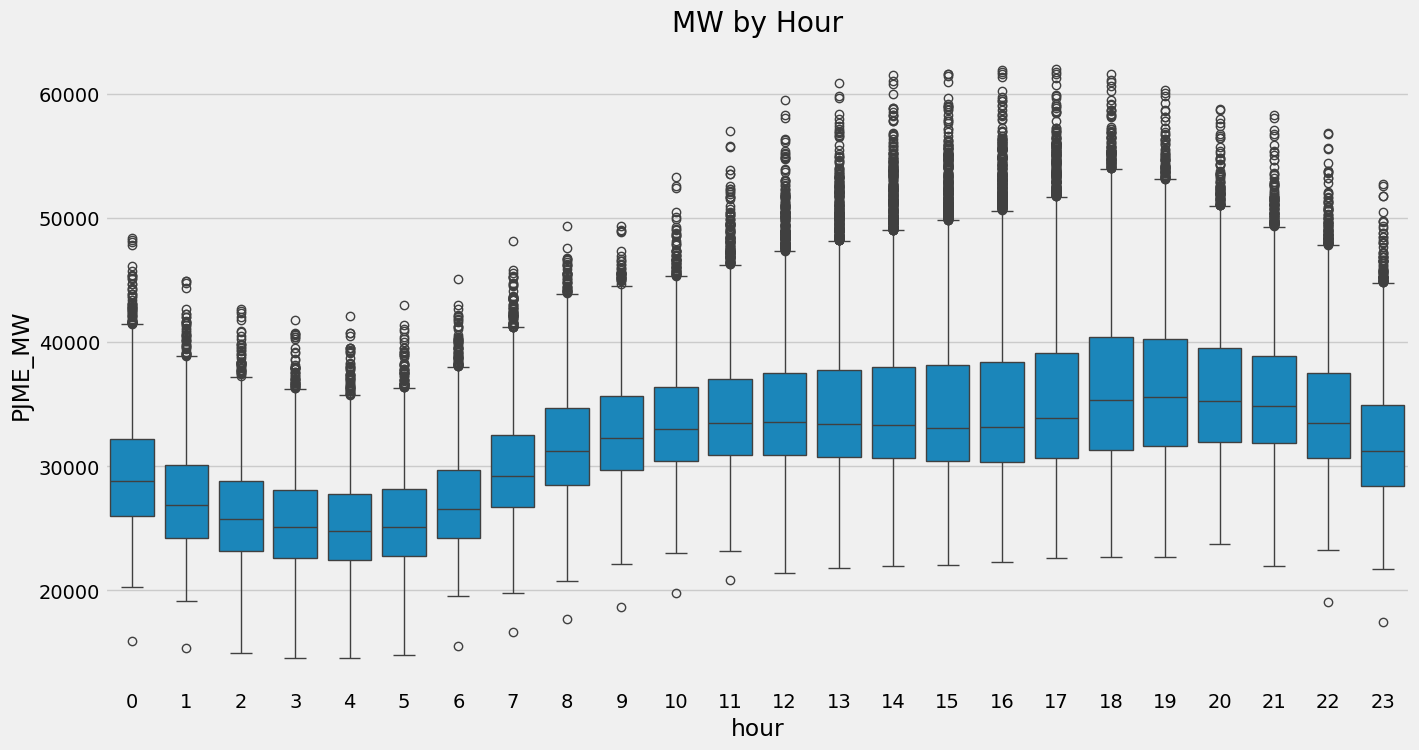

In [ ]:
fig, ax=plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

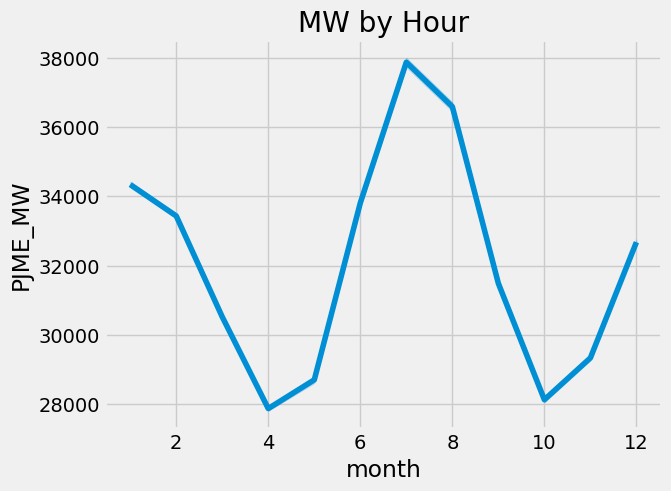

In [ ]:
sns.lineplot(x='month', y='PJME_MW', data=df)
plt.title('MW by Hour')
plt.show()

In [ ]:
train=create_features(train)
test=create_features(test)

<ipython-input-26-e33210ddf41f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']=df.index.hour
<ipython-input-26-e33210ddf41f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek']=df.index.dayofweek
<ipython-input-26-e33210ddf41f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
train

,PJME_MW,hour,dayofweek,month,dayofmonth,quarter,year,dayofyear,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,31,4,2002,365,1
2002-12-31 02:00:00,25147.0,2,1,12,31,4,2002,365,1
2002-12-31 03:00:00,24574.0,3,1,12,31,4,2002,365,1
2002-12-31 04:00:00,24393.0,4,1,12,31,4,2002,365,1
2002-12-31 05:00:00,24860.0,5,1,12,31,4,2002,365,1
...,...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,20,2,1,1,1,2014,1,1
2014-01-01 21:00:00,35601.0,21,2,1,1,1,2014,1,1
2014-01-01 22:00:00,34242.0,22,2,1,1,1,2014,1,1


In [ ]:
test

,PJME_MW,hour,dayofweek,month,dayofmonth,quarter,year,dayofyear,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,1,2015,1,1
2015-12-31 01:00:00,24305.0,1,3,12,31,4,2015,365,53
2015-12-31 02:00:00,23156.0,2,3,12,31,4,2015,365,53
2015-12-31 03:00:00,22514.0,3,3,12,31,4,2015,365,53
2015-12-31 04:00:00,22330.0,4,3,12,31,4,2015,365,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,1,2018,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,1,2018,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,1,2018,1,1


In [ ]:
features=['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target='PJME_MW'

X_train, X_test, y_train, y_test = train[features], test[features], train[target], test[target]

In [ ]:
X_train.shape

(113926, 6)

In [ ]:
def model_building(base_score, booster, n_estimators, early_stopping_rounds, objective, max_depth, learning_rate, data, test_data):
  reg=xgb.XGBRegressor(
      base_score=base_score,
      booster=booster,
      n_estimators=n_estimators,
      early_stopping_rounds=early_stopping_rounds,
      objective=objective,
      max_depth=max_depth,
      learning_rate=learning_rate)
  reg.fit(
      X_train, y_train,
      eval_set=[(X_train, y_train), (X_test, y_test)],
      verbose=100
  )

  fi=pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

  fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
  plt.show()

  print("\n")

  test_data['prediction']=reg.predict(X_test)

  df=data.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)
  ax=df[['PJME_MW']].plot(figsize=(15, 6))
  df['prediction'].plot(ax=ax, style='.')
  plt.legend(['Truth Data', 'Predictions'])
  ax.set_title('Raw Data and Prediction')
  plt.show()

  return df

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


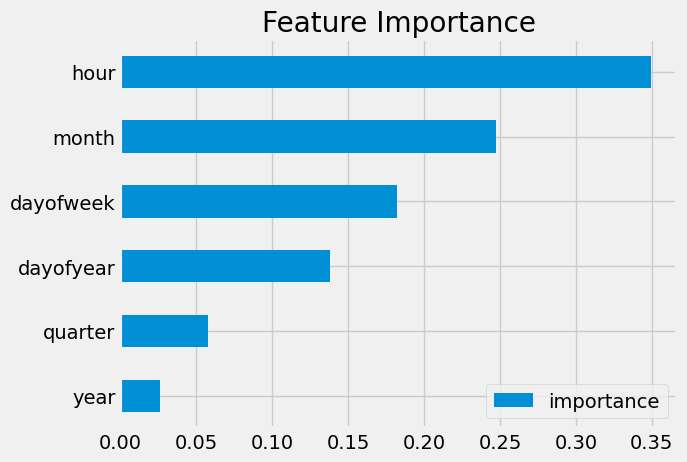

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


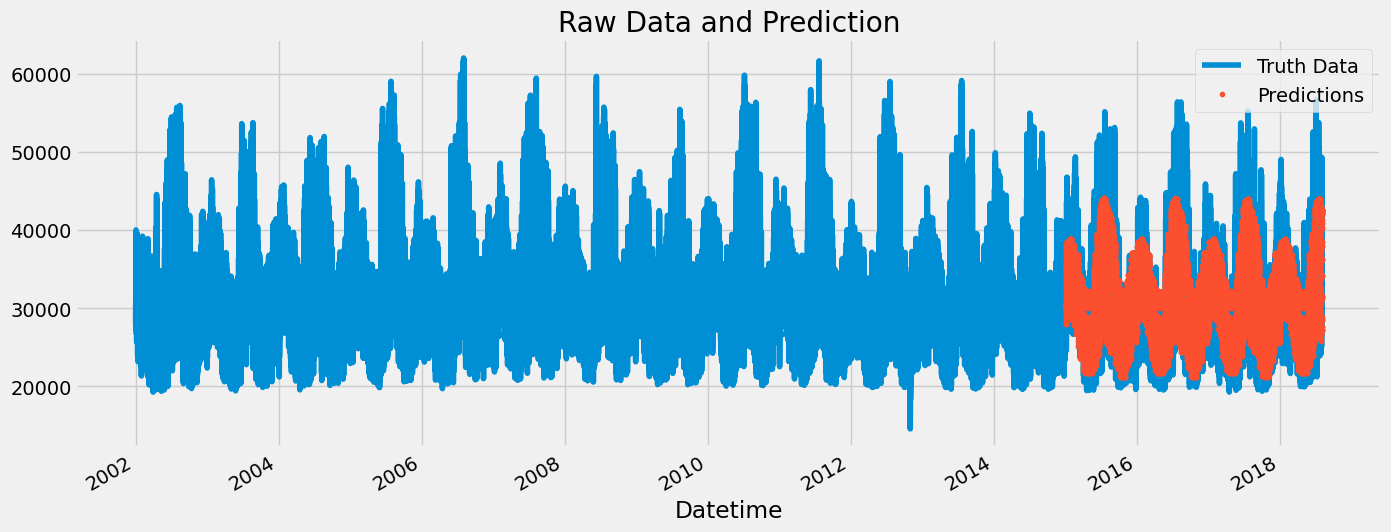

In [ ]:
df_1=model_building(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=3, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32602.32473	validation_1-rmse:31654.49189
[100]	validation_0-rmse:12386.56382	validation_1-rmse:11517.57331
[200]	validation_0-rmse:5467.28596	validation_1-rmse:5098.58780
[300]	validation_0-rmse:3514.70619	validation_1-rmse:3784.50092
[400]	validation_0-rmse:3026.88919	validation_1-rmse:3686.07146
[465]	validation_0-rmse:2909.76504	validation_1-rmse:3707.55668


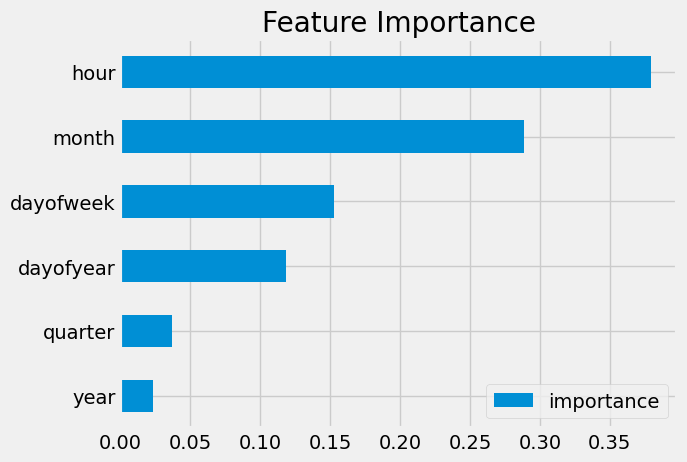

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


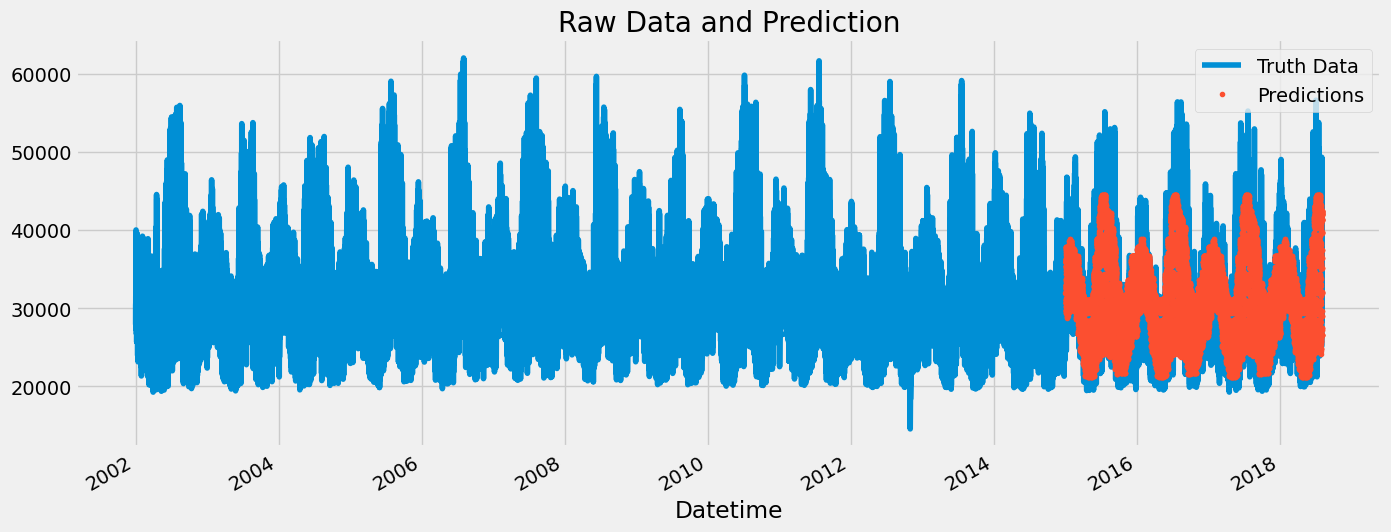

In [ ]:
df_2=model_building(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=5, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32601.30998	validation_1-rmse:31659.11693
[100]	validation_0-rmse:12253.29812	validation_1-rmse:11862.39621
[200]	validation_0-rmse:5074.08925	validation_1-rmse:5467.86865
[300]	validation_0-rmse:2818.72133	validation_1-rmse:4107.78677
[400]	validation_0-rmse:2173.36916	validation_1-rmse:4019.56851
[415]	validation_0-rmse:2128.14848	validation_1-rmse:4026.82750


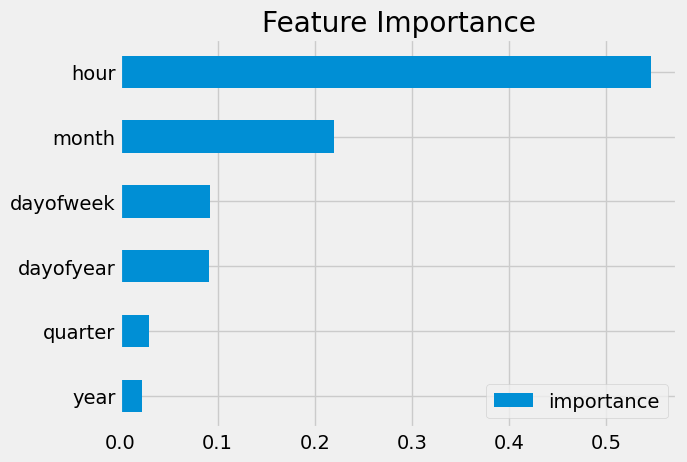

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


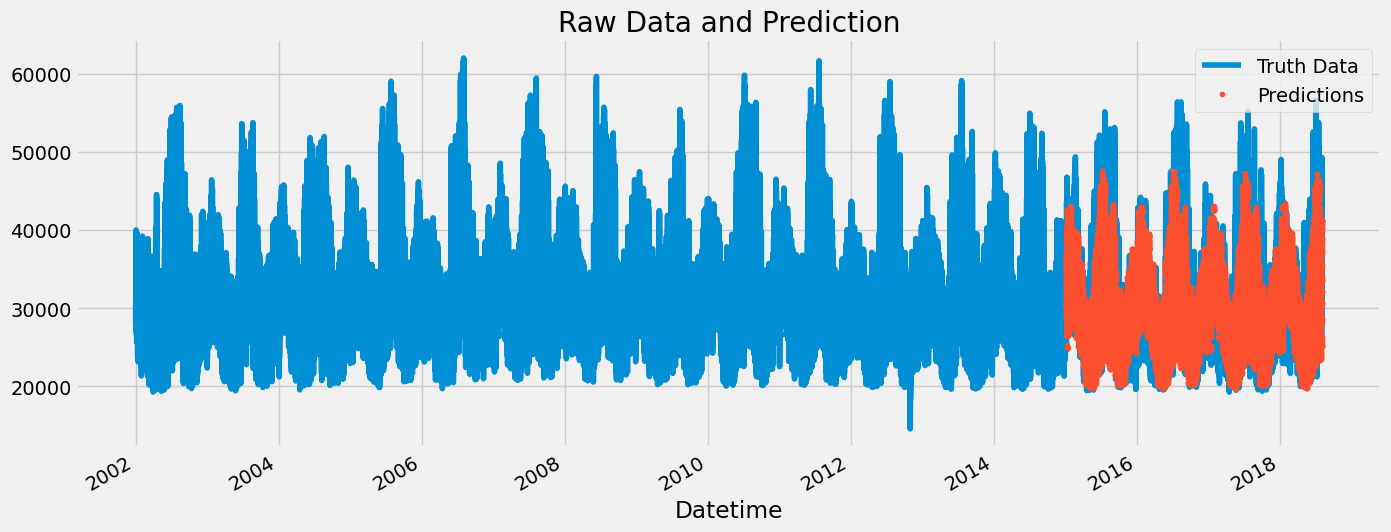

In [ ]:
df_3=model_building(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=10, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32601.58981	validation_1-rmse:31653.46509
[100]	validation_0-rmse:12308.23076	validation_1-rmse:11583.19717
[200]	validation_0-rmse:5291.22952	validation_1-rmse:5210.49284
[300]	validation_0-rmse:3245.91455	validation_1-rmse:3883.52042
[400]	validation_0-rmse:2752.51786	validation_1-rmse:3775.87767
[423]	validation_0-rmse:2684.23574	validation_1-rmse:3785.97018


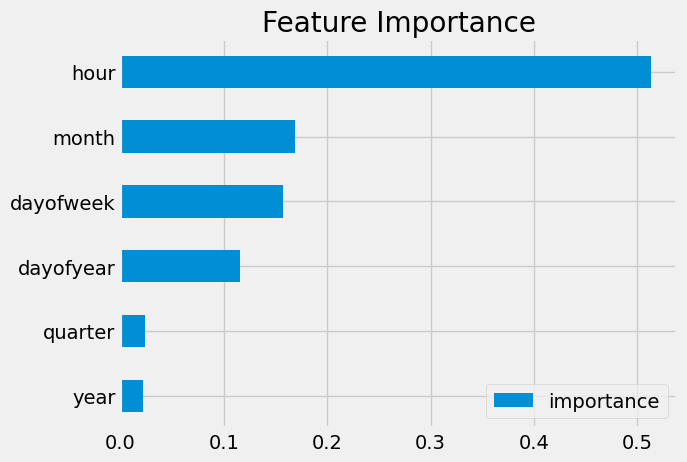

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


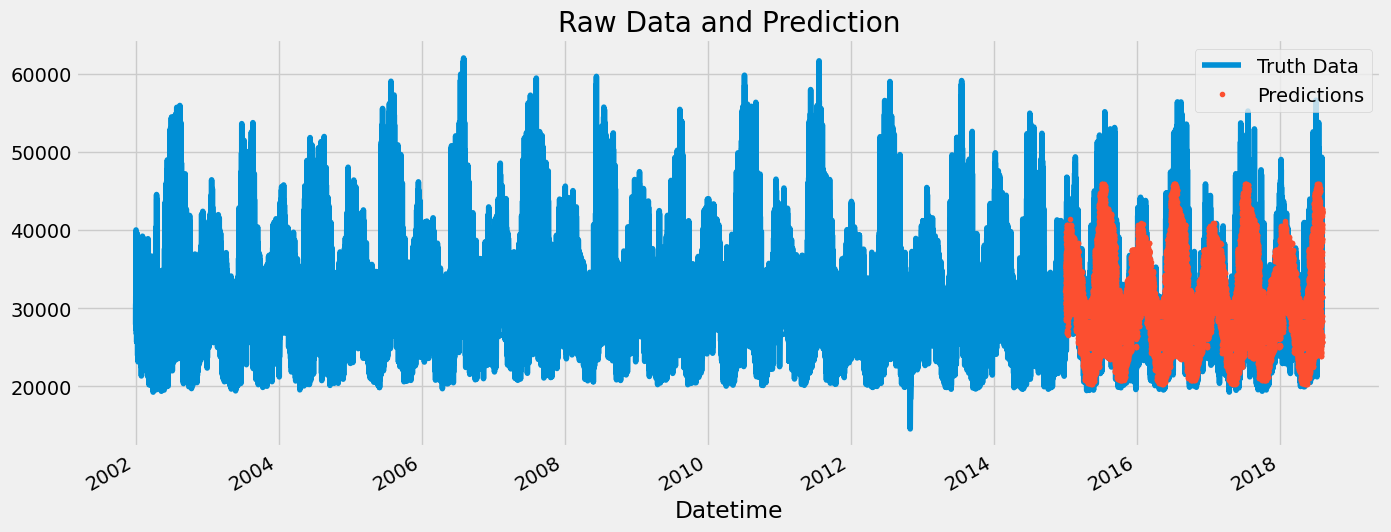

In [ ]:
df_4=model_building(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=7, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32603.52429	validation_1-rmse:31656.02074
[100]	validation_0-rmse:12465.51342	validation_1-rmse:11615.86838
[200]	validation_0-rmse:5617.55523	validation_1-rmse:5166.51410
[300]	validation_0-rmse:3705.81617	validation_1-rmse:3840.75071
[400]	validation_0-rmse:3231.58028	validation_1-rmse:3698.14848
[467]	validation_0-rmse:3110.80838	validation_1-rmse:3707.08249


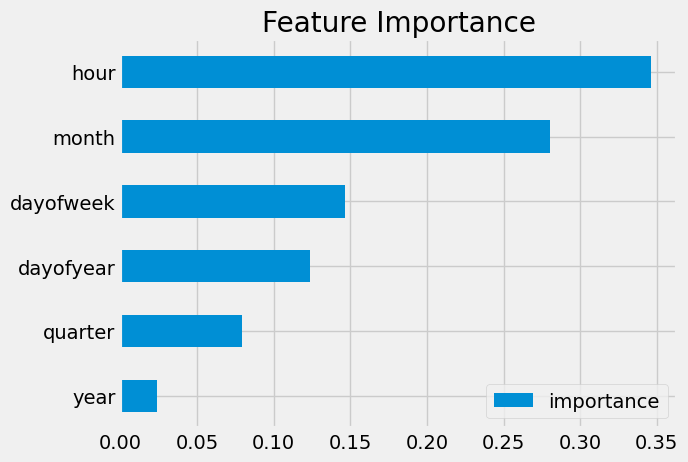

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


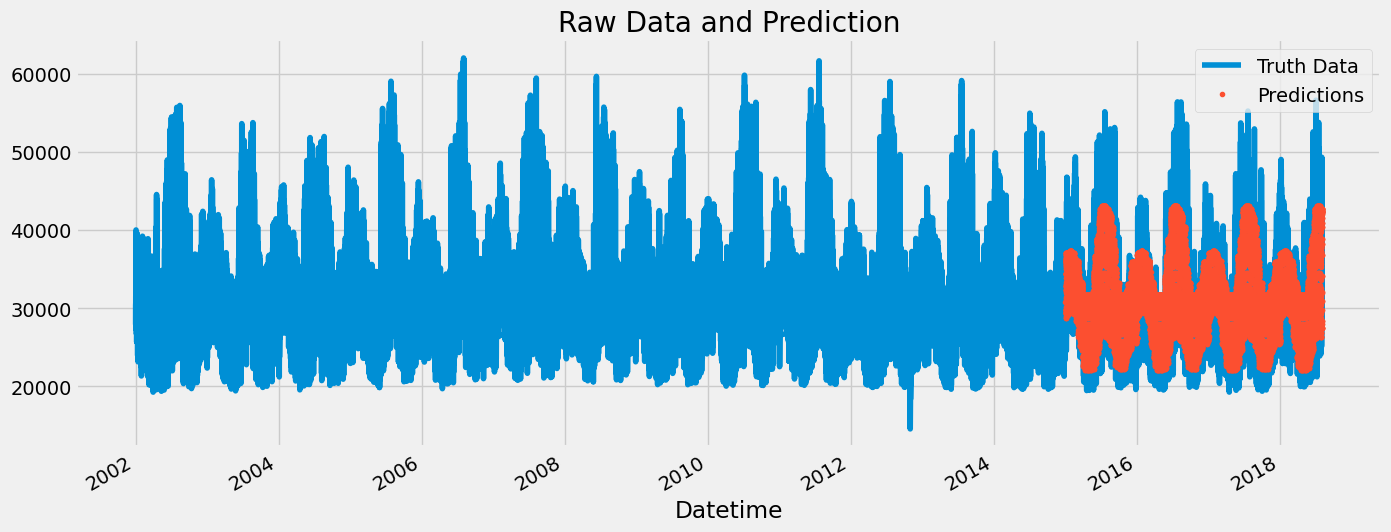

In [ ]:
df_5=model_building(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=4, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32605.76860	validation_1-rmse:31658.40156
[100]	validation_0-rmse:12778.35222	validation_1-rmse:11967.06552
[200]	validation_0-rmse:6217.48069	validation_1-rmse:5800.64825
[300]	validation_0-rmse:4373.33923	validation_1-rmse:4428.58541
[400]	validation_0-rmse:3900.57026	validation_1-rmse:4215.78223
[500]	validation_0-rmse:3731.66727	validation_1-rmse:4141.15641
[600]	validation_0-rmse:3631.06602	validation_1-rmse:4074.39914
[700]	validation_0-rmse:3560.74098	validation_1-rmse:4022.70198
[800]	validation_0-rmse:3505.96669	validation_1-rmse:3983.96178
[900]	validation_0-rmse:3454.18188	validation_1-rmse:3945.52775
[1000]	validation_0-rmse:3414.74023	validation_1-rmse:3916.23092
[1100]	validation_0-rmse:3383.83982	validation_1-rmse:3891.11728
[1200]	validation_0-rmse:3357.45690	validation_1-rmse:3870.47331
[1300]	validation_0-rmse:3329.18673	validation_1-rmse:3848.42528
[1400]	validation_0-rmse:3305.69974	validation_1-rmse:3833.33636
[1500]	validation_0-rmse:3284.192

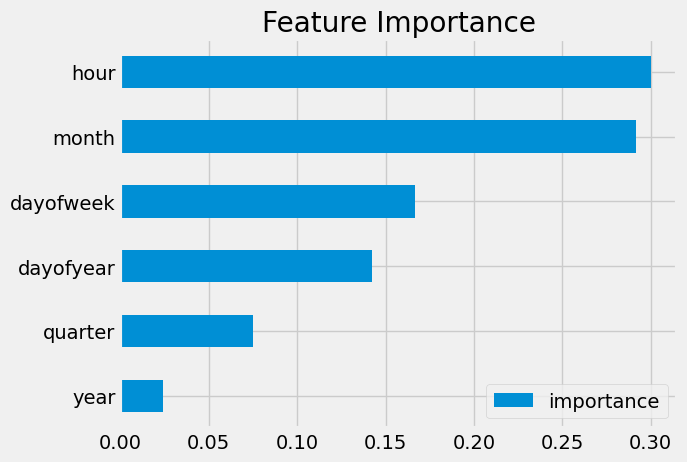

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


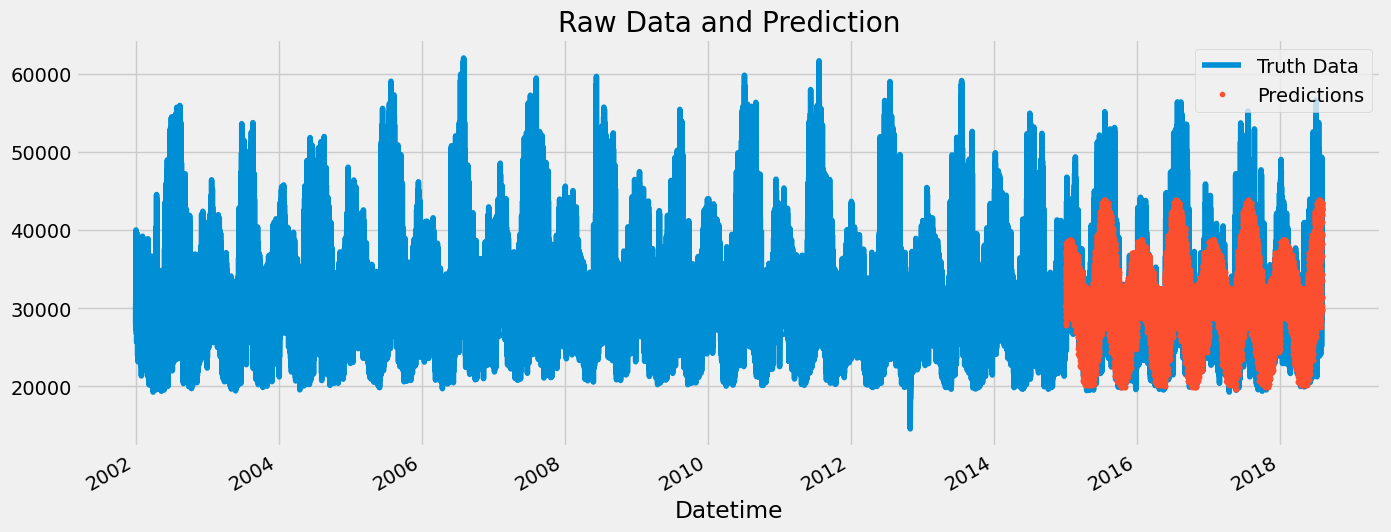

In [ ]:
df_6=model_building(base_score=0.5, booster='gbtree', n_estimators=3000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=2, learning_rate=0.01, data=df, test_data=test)

[0]	validation_0-rmse:32895.02408	validation_1-rmse:31947.18232
[100]	validation_0-rmse:29841.63327	validation_1-rmse:28899.59518
[200]	validation_0-rmse:27086.85207	validation_1-rmse:26153.64523
[300]	validation_0-rmse:24602.12858	validation_1-rmse:23677.14772
[400]	validation_0-rmse:22362.15912	validation_1-rmse:21446.33658
[500]	validation_0-rmse:20344.36186	validation_1-rmse:19439.54541
[600]	validation_0-rmse:18527.12988	validation_1-rmse:17638.20991
[700]	validation_0-rmse:16893.22089	validation_1-rmse:16019.12496
[800]	validation_0-rmse:15425.14773	validation_1-rmse:14568.33294
[900]	validation_0-rmse:14108.15059	validation_1-rmse:13271.66976
[1000]	validation_0-rmse:12928.46610	validation_1-rmse:12114.60532
[1100]	validation_0-rmse:11873.22882	validation_1-rmse:11084.93371
[1200]	validation_0-rmse:10931.54579	validation_1-rmse:10171.69138
[1300]	validation_0-rmse:10093.12753	validation_1-rmse:9364.89293
[1400]	validation_0-rmse:9339.40272	validation_1-rmse:8645.99493
[1500]	val

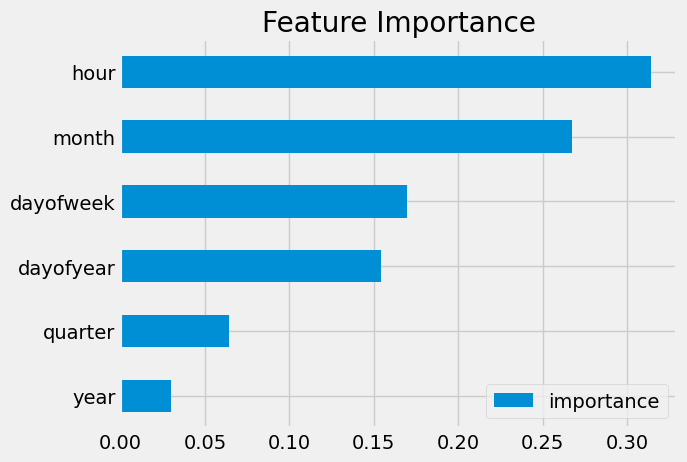

<ipython-input-49-4099236f3365>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction']=reg.predict(X_test)


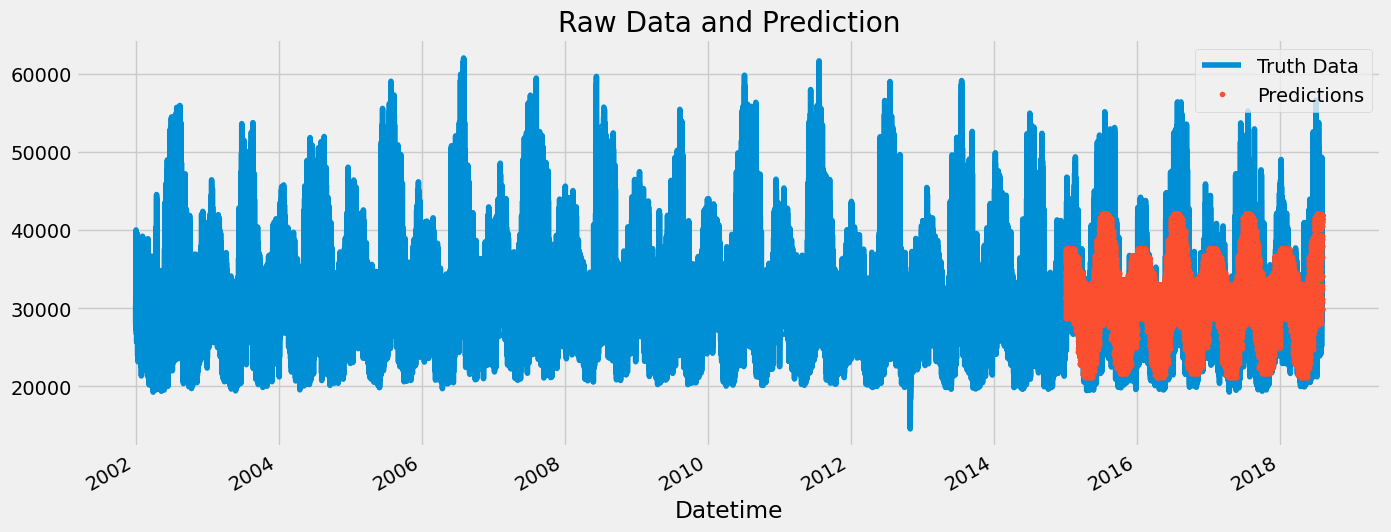

In [ ]:
df_7=model_building(base_score=0.5, booster='gbtree', n_estimators=10000, early_stopping_rounds=50, objective='reg:squarederror',
               max_depth=2, learning_rate=0.001, data=df, test_data=test)

In [ ]:
df_1

,PJME_MW,hour,dayofweek,month,dayofmonth,quarter,year,dayofyear,weekofyear,prediction
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,31,4,2002,365,1,NaN
2002-12-31 02:00:00,25147.0,2,1,12,31,4,2002,365,1,NaN
2002-12-31 03:00:00,24574.0,3,1,12,31,4,2002,365,1,NaN
2002-12-31 04:00:00,24393.0,4,1,12,31,4,2002,365,1,NaN
2002-12-31 05:00:00,24860.0,5,1,12,31,4,2002,365,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,1,2018,1,1,37738.308594
2018-01-01 21:00:00,43751.0,21,0,1,1,1,2018,1,1,37685.746094
2018-01-01 22:00:00,42402.0,22,0,1,1,1,2018,1,1,36207.367188


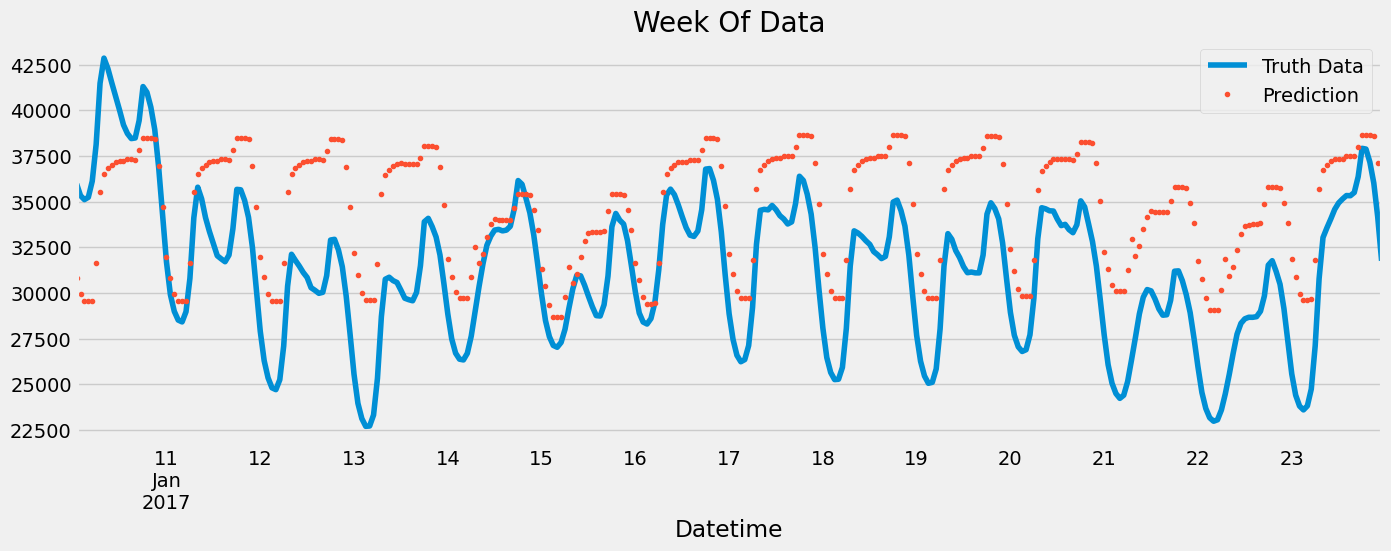

In [ ]:
df_resampled2=df_1.loc[(df_1.index > "01-10-2017") & (df_1.index < "01-24-2017")].resample("h").mean()

ax=df_resampled2.loc[(df_resampled2.index > '01-10-2017') & (df_resampled2.index < '01-24-2017')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_resampled2.loc[(df_resampled2.index > '01-10-2017') & (df_resampled2.index < '01-24-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score=np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3917.84


In [ ]:
test['error']=np.abs(test[target] - test['prediction'])
test['date']=test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

<ipython-input-65-3f81d5c14c24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error']=np.abs(test[target] - test['prediction'])
<ipython-input-65-3f81d5c14c24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date']=test.index.date


,error
date,
2016-08-13,11272.972249
2015-02-20,11107.639567
2018-01-06,11042.439453
2016-08-14,10991.774251
2016-09-09,10706.344238
2016-09-10,10579.884033
2018-01-07,10113.690837
2015-02-21,10011.111084
2015-02-16,9718.680420
